# Simple Monitoring plots from ECHAM6 monthly mean output
Currently the standard BOT files that are produced by the postprocessing are used.

In [1]:
# this is the parameters cell for papermill
# Via papermill (https://papermill.readthedocs.io/en/latest/) the settings below can be overwritten via command line arguments. 
# This allows to run this notebook in batch mode. The cell below is tagged as parameter cell. 
expid = "FOCI3.0-SW003"
iniyear = 1850
exproot = "/Users/swahl/data/esm-experiments"
obsroot =  "/Users/swahl/data/foci_input2/OBS_MONITORING/T63/"

In [2]:
# settings that can overwritten by command line arguments
# only required at a later stage, 
# in normal monitoring mode startyear and endyear are detected automatically
monitoring = {
    'exproot': exproot,
    'obsroot': obsroot,
    'iniyear': iniyear,
    'expid': expid,
}

monitoring['ftype'] = {
    'echam6_BOT_mm': {
        'vars_lineplot': ['temp2', 'tsw', 'toa', 'aclcov' ,'precip', 'evap', 'net_water_flux'],
        'vars_mapplot': ['tsw','temp2','precip'],
    }
}    

varopts = {
    'toa': {
        'long_name': 'TOA radiation balance'
    },
    'temp2': {
        'offset': -273.15,
        'scale_factor': 1.0,
        # obs_* and plot settings are only relevant for bias map plots, not for line plots
        'use_obs': True,
        'obs_path': f'{monitoring["obsroot"]}/t2m-eraint_monthly_T63_1979-2013.nc',
        'obs_varname': 't2m',
        'obs_timerange': ['1980-01-01','2009-12-31'], # currently not used
        'plotlevels': [-6,-5,-4,-3,-2,-1,1,2,3,4,5,6],
    },
    'tsw': {
        'offset': -273.15,
        'scale_factor': 1.0,
        'use_obs': True,
        'obs_path': f'{monitoring["obsroot"]}/HADISST_1_1_SST_1950-2004_T63.nc',
        'obs_varname': 'sst',
        'obs_timerange': ['1980-01-01','2004-12-31'], # currently not used
        'plotlevels': [-6,-5,-4,-3,-2,-1,1,2,3,4,5,6],
    },
    'precip': {
        'scale_factor': 86400.0,
        'use_obs': True,
        'obs_path': f'{monitoring["obsroot"]}/gpcp_monthly_precip_T63_1979-2013.nc',
        'obs_varname': 'precip',
        'obs_timerange': ['1980-01-01','2004-12-31'], # currently not used
        'plotlevels': [-6,-5,-4,-3,-2,-1,1,2,3,4,5,6],
        'cmap': 'RdBu'
    }
}

plotopts = {}
monitoring['echamroot'] = f'{monitoring["exproot"]}/{monitoring["expid"]}/outdata/echam6'
monitoring['echammonroot'] = f'{monitoring["exproot"]}/{monitoring["expid"]}/mon/echam'

In [3]:
import xarray as xr
import seaborn as sns
import pandas as pd
import numpy as np
from cartopy import crs as ccrs # Cartography library
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
import os.path
import glob
import random
import multiprocessing
from functools import partial
import warnings
warnings.filterwarnings('ignore')
#import shutil
from cdo import *
# TODO: I hope it will work this way:
# 1. in interactive mode, set path to cdo below, maybe I prepare some if machine then cdo = default settings
# 2. in batch mode, cdo should work without the os.environ['CDO'] settings below
# os.environ['CDO'] = '/home/shkifmsw/bin/cdo'
#cdo = Cdo(cdo='/home/shkifmsw/bin/cdo')
cdo = Cdo()

In [4]:
# run cdo operations in parallel
def cdo_parallel(year,monitoring):
    '''
    Wrapper function to run cdo in parallel
    '''
    for ftype in monitoring.get('ftype').keys():
        infile=f"{monitoring['echamroot']}/{monitoring['expid']}_{ftype}_{year:04d}.nc"
        singleyear=f"{monitoring['echammonroot']}/{monitoring['expid']}_{ftype}_{year:04d}_yearmean.nc"
        singleyearfldmean=f"{monitoring['echammonroot']}/{monitoring['expid']}_{ftype}_{year:04d}_yearfldmean.nc"
        #if os.path.exists(singleyear): num_years=num_years+1
        if os.path.exists(infile):
            if not os.path.exists(singleyear): cdo.yearmean(input=infile, output=singleyear)
            if not os.path.exists(singleyearfldmean): cdo.fldmean(input=singleyear, output=singleyearfldmean)

            
def find_startyear_endyear(monitoring):
    '''
    Automagically finds start year and end year by checking the existing monitoring file and
    then walking through the model output to find the last year
    '''
    # check if a yearmean.nc file exists, and get last year from file
    startyear = monitoring['iniyear']
    # assume that all filetypes have been processed to the same endyear
    ftype = list(monitoring.get('ftype').keys())[-1]
    
    yearmeanfile = f"{monitoring['echammonroot']}/{monitoring['expid']}_{ftype}_yearfldmean.nc"
    if os.path.exists(yearmeanfile):
        ds = xr.open_dataset(yearmeanfile)
        startyear = ds.time.values[-1].astype('datetime64[Y]').astype(int) + 1970 + 1
    endyear = startyear

    # find last file if the endyear request is larger than the startyear
    # which has been automatically detected above.
    # If the startyear == endyear no calculations need to be performed. This can happen
    # if we rerun the code manually
    for year in range(startyear,startyear+10000): # 10000 is arbitrary
        if os.path.exists(f"{monitoring['echamroot']}/{monitoring['expid']}_{ftype}_{year:04d}.nc"):
            endyear = year
        else:
            break
            
    return startyear,endyear

startyear, endyear = find_startyear_endyear(monitoring)

if endyear > startyear:

    years = list(range(startyear,endyear+1))
    pool = multiprocessing.Pool(processes=8)
    run_cdo = partial(cdo_parallel, monitoring=monitoring)
    result_list = pool.map(run_cdo, years)
    
    for ftype in monitoring.get('ftype').keys():
        for f in ["yearmean","yearfldmean"]:
            if os.path.exists(f"{monitoring['echammonroot']}/{monitoring['expid']}_{ftype}_{endyear}_{f}.nc"):
                meanfile = f"{monitoring['echammonroot']}/{monitoring['expid']}_{ftype}_{f}.nc"
                if os.path.exists(meanfile):
                    tmpfile=f"{monitoring['echammonroot']}/tmp_{random.randint(0,10000)}.nc"
                    cdo.mergetime(input=f"{meanfile} {monitoring['echammonroot']}/{monitoring['expid']}_{ftype}_????_{f}.nc", output=tmpfile)
                    os.remove(meanfile); os.rename(tmpfile,meanfile)
                else:
                    cdo.mergetime(input=f"{monitoring['echammonroot']}/{monitoring['expid']}_{ftype}_????_{f}.nc", output=meanfile)

                for f in glob.glob(f"{monitoring['echammonroot']}/{monitoring['expid']}_{ftype}_????_{f}.nc"): os.remove(f)
else:
    print(f'{startyear} <= {endyear}, no calculations need to be performed.')

1900 <= 1900, no calculations need to be performed.


## Monitoring plots for ECHAM6 surface data

In [12]:
# functions to make plots look nice
col_blind = sns.color_palette("colorblind", 10)
sns.set_style('ticks')
sns.set_palette(col_blind)
sns.set_context("notebook", font_scale=1., rc={"lines.linewidth": 1.5})

def set_number_of_subplots(varlist,x=1):
    '''
    Calculate reasonable subplot layout, based on the number of variables
    to be plotted.
    '''
    num_plots_x = x
    num_plots_y = np.ceil( len(varlist) / num_plots_x).astype(int)
    return num_plots_x, num_plots_y

def derived_vars(ds,var,varopts):
    '''
    Calculate derived variables for monitoring and/or apply scaling and offset'
    '''
    if var == 'toa':
        var_data = ds['srad0'] + ds['trad0']     
    elif var == 'net_water_flux':
        var_data = ds['precip'] + ds['evap']
    else:
        var_data = ds[var]
        var_data.attrs = ds[var].attrs
        
    if varopts.get(var):
        var_data = var_data * varopts[var].get('scale_factor',1.0) + varopts[var].get('offset',0) 
        
    return var_data

def prepare_map_plot(ds,var,varopts):
    '''
    Calculate mean over the last 20 yearly means from the monitoring file
    produced by cdo above. If less than 20 years are available the last x years are taken
    OBS data is averaged over the entire time given in the input file for simplicity
    Also add plot options to variable attributes for easier use in cell that actually does the plots.
    '''
    var_data = derived_vars(ds,var,varopts)
    n_years = 20
    
    if varopts.get(var):
        if varopts[var].get('use_obs',False):
            obs_start = varopts[var].get('obs_timerange')[0]
            obs_end = varopts[var].get('obs_timerange')[1]
            obs_file = xr.open_dataset(varopts[var].get('obs_path')) 
            obs_data = obs_file[varopts[var].get('obs_varname',var)] * varopts[var].get('scale_factor',1.0) + varopts[var].get('offset',0)
            # use up to the last 20 years to calculate the mean
            var_data = var_data[-n_years:,:,:].mean(dim='time')
            var_data.values[:,:] = var_data.values[:,:] - obs_data.mean(dim='time').values[:,:]
        else:
            var_data = var_data[-n_years:,:,:].mean(dim='time')
            
        if varopts[var].get('long_name'):
            var_data.attrs['long_name'] = varopts[var].get('long_name',var)
        if varopts[var].get('plotlevels'):
            var_data.attrs['plotlevels'] = varopts[var].get('plotlevels')
        else:
            spacing = (var_data.max() - var_data.max())/10
            var_data.attrs['plotlevels'] = np.linspace(var_data.min()+spacing,var_data.max()-spacing,10)
            
        var_data.attrs['cmap'] = varopts[var].get('cmap','RdBu_r')
    else:
        var_data = var_data[-n_years:,:,:].mean(dim='time')
        
    return var_data

## Line plots for ECHAM6 output

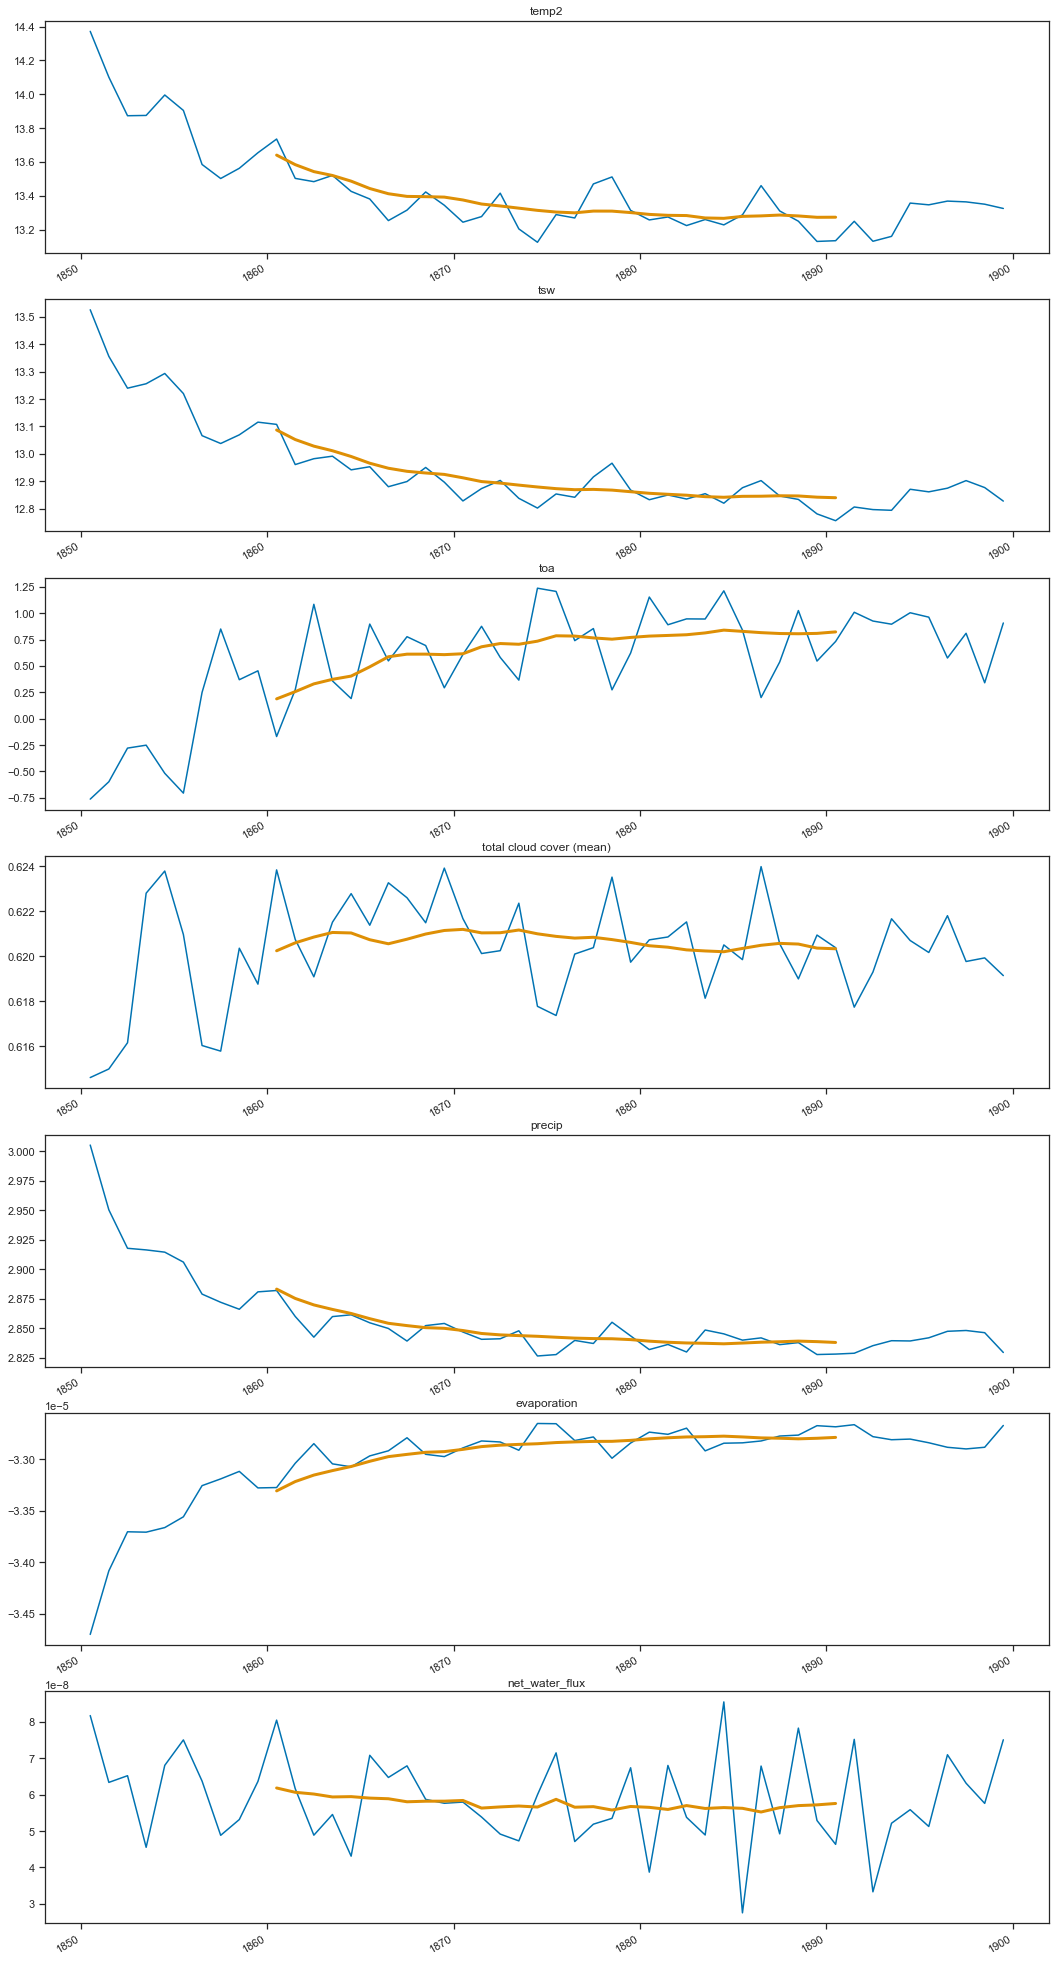

In [13]:
for ftypes in monitoring.get('ftype').keys():
    
    num_plots_x, num_plots_y = set_number_of_subplots(monitoring['ftype'].get(ftypes).get('vars_lineplot'))
    
    fldmeandata = xr.open_dataset(f"{monitoring['echammonroot']}/{monitoring['expid']}_{ftypes}_yearfldmean.nc")

    # line plots
    fig, axs = plt.subplots(num_plots_y, num_plots_x, figsize=(max(num_plots_x*6,18),num_plots_y*5))
    i=-1
    for var in monitoring['ftype'].get(ftypes).get('vars_lineplot'):
        i=i+1
        ax = axs.flat[i]
        var_data = derived_vars(fldmeandata,var,varopts)
        p = var_data.plot(ax=ax)
        if var_data['time'].size > 40:
            p2 = var_data.rolling(time=20,center=True).mean().plot(ax=ax,linewidth=3)
        ax.set_title(var_data.attrs.get('long_name',var))
        ax.set_xlabel('')
        ax.set_ylabel('')
        

## Map plots for ECHAM6 output

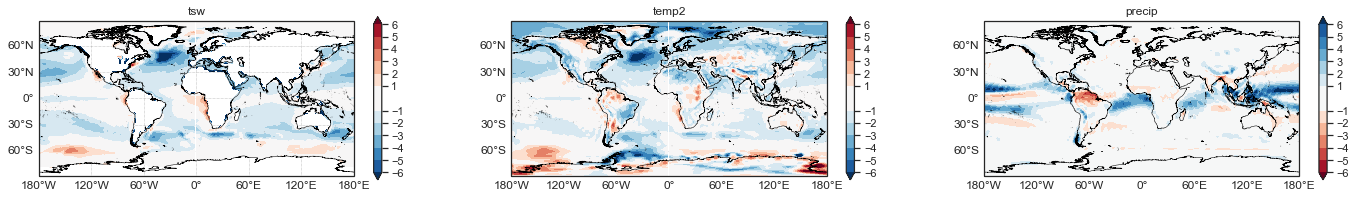

In [16]:
# map plots

for ftypes in monitoring.get('ftype').keys():

    yearmeandata = xr.open_dataset(f"{monitoring['echammonroot']}/{monitoring['expid']}_{ftypes}_yearmean.nc")
    
    num_plots_x, num_plots_y = set_number_of_subplots(monitoring['ftype'].get(ftypes).get('vars_mapplot'),x=3)
    proj = ccrs.PlateCarree()
    fig, axs = plt.subplots(num_plots_y, num_plots_x, 
                            figsize=(num_plots_x*8,num_plots_y*5), 
                            subplot_kw={'projection': proj})
    
    i=-1
    for var in monitoring['ftype'].get(ftypes).get('vars_mapplot'):
        i=i+1
        ax = axs.flat[i]
        var_data = prepare_map_plot(yearmeandata,var,varopts)
        p = var_data.plot.contourf(
            ax=ax,
            transform=ccrs.PlateCarree(),                      
            #cmap='RdYlBu_r',
            cmap=var_data.attrs['cmap'],
            levels=var_data.attrs['plotlevels'],
            extend='both',
            cbar_kwargs={'label': '',
                        'extend': 'both','shrink': 0.6,
                         'orientation': 'vertical',
                         'spacing': 'proportional',
                         'ticks': var_data.attrs['plotlevels']
                        }
            )
        ax.set_title(var_data.attrs.get('long_name',var))
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.coastlines(resolution='10m', lw=0.51)
        
        gl = ax.gridlines(crs=ccrs.PlateCarree(), linestyle='dotted',color='black',
                  linewidth=0.5, alpha=0.5,
                  draw_labels=True, zorder=.3)

        gl.top_labels = False
        gl.right_labels = False
        gl.left_labels = True
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER